### Задача  
Используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.

Импортируем билиотеки, которые понадобятся для решения задачи

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [14, 7]

In [2]:
lectures = pd.read_csv("lectures.csv")
print(f"Размер датафрейма lectures: {lectures.shape}")
lectures.head()

Размер датафрейма lectures: (418, 4)


,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [3]:
lectures['type_of'].value_counts()

type_of
concept             222
solving question    186
intention             7
starter               3
Name: count, dtype: int64

In [4]:
questions = pd.read_csv("questions.csv")
print(f"Размер датафрейма questions: {questions.shape}")
questions.head()

Размер датафрейма questions: (13523, 5)


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


Теги представлены в вид строки, но кажется должны быть в формате списка. Не знаю зачем, но преобразуем

In [5]:
questions['tags'] = questions['tags'].str.split(" ")

Считываем основной датафрейм. Указываем типы данных, чтобы уменьшить потребление оперативной памяти

In [6]:
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"
}

df = pd.read_csv("train.csv",  dtype=dtypes)
df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,<NA>
1,1,56943,115,5716,False,2,2,1,37000.0,False
2,2,118363,115,128,False,0,0,1,55000.0,False
3,3,131167,115,7860,False,3,0,1,19000.0,False
4,4,137965,115,7922,False,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
101230327,101230327,428564420,2147482888,3586,False,22,0,1,18000.0,True
101230328,101230328,428585000,2147482888,6341,False,23,3,1,14000.0,True
101230329,101230329,428613475,2147482888,4212,False,24,3,1,14000.0,True
101230330,101230330,428649406,2147482888,6343,False,25,1,0,22000.0,True


Нас не интересуют колонки `row_id` (так как уже есть индекс) и `user_answer`, так как мы ни с чем не сможем его связать. Единственное, мы можем проверить, всегда ли если `user_answer` == `correct_answer` из файла **questions.csv**, то колонка `answered_correctly` принимает значение 1. Но предположим, что здесь проблем нет  
`content_id` так же не будем использовать, поэтому удалим для экономии места

In [7]:
df = df.drop(columns=["row_id", "user_answer", "content_id"])

Посмотрим на пропуски в данных

In [8]:
df.isna().sum()

timestamp                               0
user_id                                 0
content_type_id                         0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time       2351538
prior_question_had_explanation     392506
dtype: int64

Далее оценим распределение всех числовых и категориальных переменных. Кроме, конечно, user_id

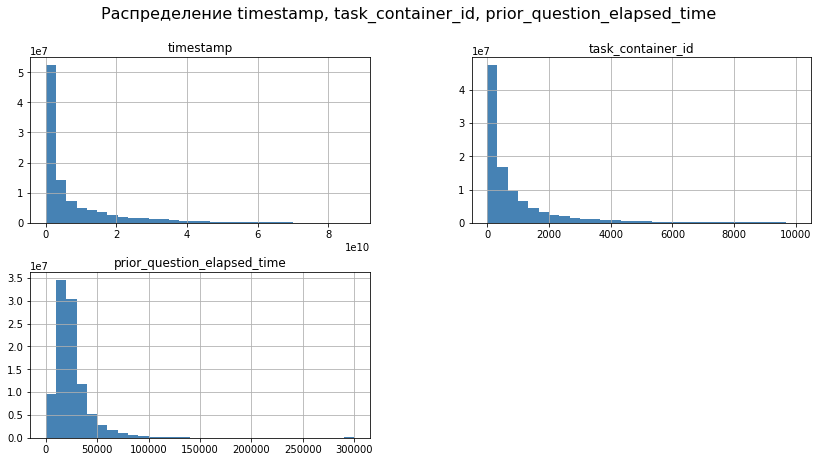

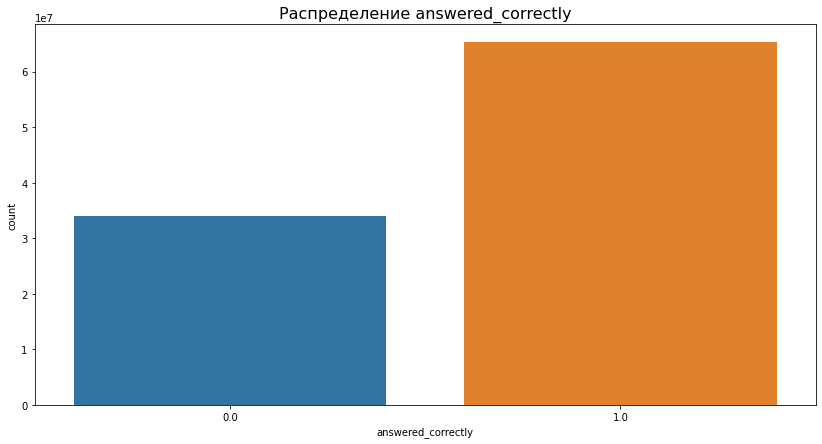

In [15]:
num_cols = ["timestamp", "task_container_id", "prior_question_elapsed_time"]
cat_cols = ["answered_correctly"]
df[num_cols].hist(bins=30, color='steelblue')
plt.suptitle(f'Распределение {", ".join(num_cols)}', size=16)
plt.show()

# Распределение категориальных переменных
for col in cat_cols:
    sns.countplot(data=df, x=col)
    plt.title(f'Распределение {col}', size=16)
    plt.show()

По задаче нам нужно найти параметры, влияющие на успеваемость. Однако вопрос: что считать успеваемостью. Явной колонки с таким значением у нас нет, поэтому мы вынуждены расчитать её самостоятельно. Примем за *успеваемость* долю правильных ответов среди всех ответов студента  
Однако вспомним, что колонка `answered_correctly` может принимать значение -1 для лекций, поэтому преобразуем её в NaN

In [9]:
df['answered_correctly'] = df['answered_correctly'].where(df['answered_correctly'] != -1)

Теперь найдём успеваемость для каждого студента, а так же число просмотренных лекций (`content_type_id`), усреднённые показатели по времени решения задачи (`prior_question_elapsed_time`), число пройденных тестов (`task_container_id`), долю использований объяснений в задачах (`prior_question_had_explanation`)

In [10]:
students = df.groupby("user_id", as_index=False).agg(grade=("answered_correctly", "mean"),
                                                     lections=("content_type_id", "sum"),
                                                     total_tests=("task_container_id", "nunique"),
                                                     time_per_question=("prior_question_elapsed_time", "mean"),
                                                     explanation_usage=("prior_question_had_explanation", "mean"))
students

,user_id,grade,lections,total_tests,time_per_question,explanation_usage
0,115,0.695652,0,42,19933.310547,0.133333
1,124,0.233333,0,16,18793.000000,0.0
2,2746,0.578947,1,20,18055.554688,0.578947
3,5382,0.672000,3,128,36048.386719,0.889764
4,8623,0.642202,3,100,26107.408203,0.864865
...,...,...,...,...,...,...
393651,2147470770,0.765487,2,214,23167.382812,0.859031
393652,2147470777,0.691489,6,482,20028.103516,0.952444
393653,2147481750,0.760000,0,50,17938.775391,0.795918
393654,2147482216,0.643636,5,280,19562.042969,0.953405


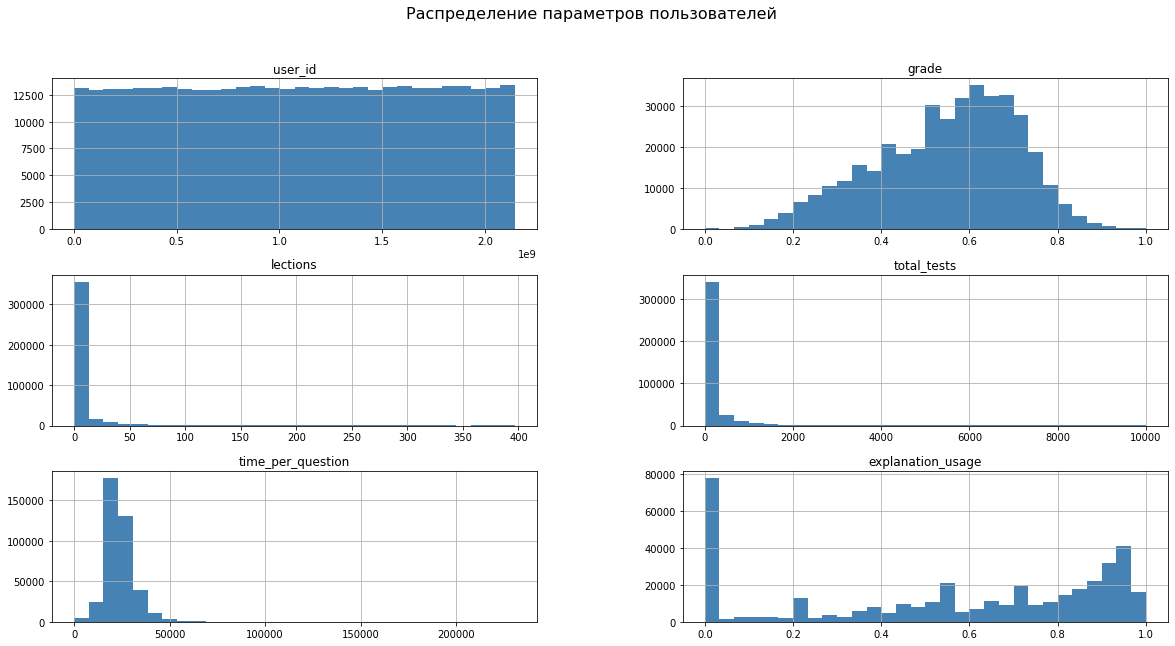

In [16]:
students.hist(bins=30, color='steelblue', figsize=(20, 10))
plt.suptitle(f'Распределение параметров пользователей', size=16)
plt.show()

- Заметим, что большая часть студентов посещает очень мало лекций. Аналогично с тестами  
- Среднее время ответа на вопрос имеет нормальное распределение
- Студенты нередко используют пояснения к вопросам

Оценим как переменные коррелируют между собой

Text(0.5, 1.0, 'Матрица корреляции')

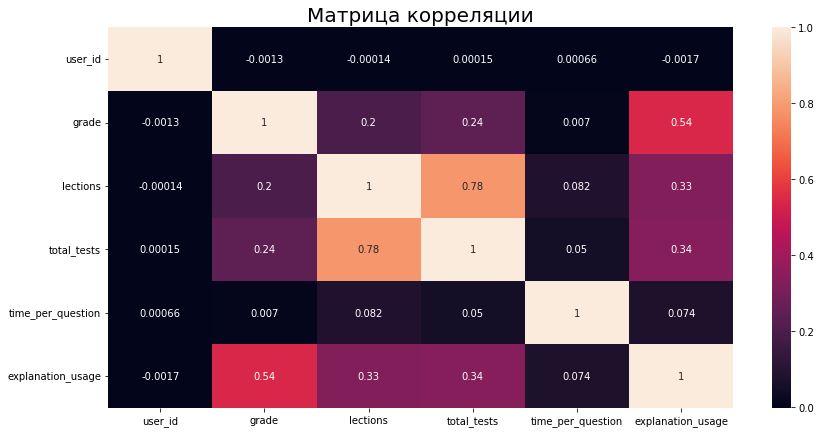

In [17]:
sns.heatmap(students.corr(), annot=True)
plt.title("Матрица корреляции", size=20)

Из расчитанных нами переменных только частота использования объяснений к вопросам явно коррелирует с успеваемостью. В принципе, это кажется логичным. Так же слабая корреляция с нашей целевой переменной у числа прослушанных лекций и количества решённых тестов. Построим модель линейной регрессии

Перед применением регрессии посмотрим были ли пропуски в колонках. Удалим

In [18]:
print(students.isna().sum())
students = students.dropna()

user_id               0
grade                 0
lections              0
total_tests           0
time_per_question    87
explanation_usage    87
dtype: int64


In [19]:
import statsmodels.api as sm
# Преобразуем числа в единый формат, чтобы не ругалось
students = students.astype("float")
# Определим целевую переменную (grade) и предикторы (все остальные столбцы, кроме user_id)
X = students[['explanation_usage', 'lections', 'total_tests', 'time_per_question']]
y = students['grade']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  grade   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                 4.158e+04
Date:                Sat, 19 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:48:55   Log-Likelihood:             2.2431e+05
No. Observations:              393569   AIC:                        -4.486e+05
Df Residuals:                  393564   BIC:                        -4.486e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4225      0.00

Во - первых, видим не совсем высокий уровень $R^2$ для модели  
Во - вторых, вывод указывает на сильную мультиколлинеарность, что так же не очень хорошо. Чтобы повысить качество модели оставим два признака, которые имеют хоть сколько нибудь заметную корреляцию

In [25]:
X = students[['explanation_usage', 'lections']]
y = students['grade']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  grade   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 8.081e+04
Date:                Sat, 19 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:50:08   Log-Likelihood:             2.2265e+05
No. Observations:              393569   AIC:                        -4.453e+05
Df Residuals:                  393566   BIC:                        -4.453e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4067      0.00

Хотя модель объясняет лишь небольшую долю изменчивости переменной `grade`, так она хотя бы корректна  

В итоге на успеваемость студентов влияет то, как часто они используют пояснение к предыдущей задаче. Число просмотренных лекций можно не учитывать из - за почти нулевого коэффициента корреляции